In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing with average daily gas and electricity

- load "raw dataset", this is based on Eoghan's notebook. this dataset contains each day's average hourly energy use. 

- compare the average value from "raw dataset" with benchmark (result is electricity are reasonable, but gas use is odd)

- check and deal with outliers of gas

- check and deal with 0 and nan value of gas 

after above step, we get a reasonable gas use, so we can get a "reasonable" dataset, named it by "original"

- check missing date (missing rows) during the whole datatime period

- imputed missing rows and its data by KNN, get imputed results 

- select a whole year (365 days) data from imputated results for use. (because we will use annual income to calculate energy poverty, so here we need a one year data)

- check the average gas and electricity use results in the selected data, comapre it with "original" dataset and benchmark. 



# check  average hourly gas and electricy

In [3]:
#load daily energy use data based on results from EM's data preprocess script

energy_use = pd.read_csv('daily_demand_and_weather.csv')
energy_use.head(15)


,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,6832.0,253.0
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0
5,100,2017-03-12,11.0,4.0,Clear,6.0,True,False,3855.0,324.0
6,100,2017-03-13,12.0,9.0,Partly Cloudy,0.0,False,False,1106.0,231.0
7,100,2017-03-14,12.0,5.0,Partly Cloudy,1.0,False,False,1643.0,223.0
8,100,2017-03-15,13.0,8.0,Mostly Cloudy,2.0,False,False,3339.0,248.0
9,100,2017-03-16,12.0,3.0,Chance of Rain,3.0,False,False,6467.0,222.0


In [ ]:
energy_use['datetime'] = pd.to_datetime(energy_use['datetime'])
energy_use['year'] = pd.to_datetime(energy_use['datetime']).dt.year
energy_use['month'] = pd.to_datetime(energy_use['datetime']).dt.month
energy_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71606 entries, 0 to 71605
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   household_id                    71606 non-null  int64         
 1   datetime                        71606 non-null  datetime64[ns]
 2   maxtemp                         59439 non-null  float64       
 3   mintemp                         59439 non-null  float64       
 4   conditions                      59439 non-null  object        
 5   day_of_week                     59439 non-null  float64       
 6   is_weekend                      59439 non-null  object        
 7   is_bank_holiday                 59439 non-null  object        
 8   mean_rounded_gas_pulse          59841 non-null  float64       
 9   mean_rounded_electric_combined  66661 non-null  float64       
 10  year                            71606 non-null  int32         
 11  mo

# check average monthly and yearly total energy demand

In [ ]:
# check average of gas_pulse and electric_combined for each month
energy_use.groupby(by=['month'])[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()

,mean_rounded_gas_pulse,mean_rounded_electric_combined
month,,
1,6942.190936,426.068660
2,8355.007614,410.420634
3,6555.932330,400.290306
4,5166.905042,352.550013
5,2754.103287,322.973836
6,1971.955325,314.749609
7,2518.209081,324.970523
8,2693.767107,346.724219
9,3718.398145,351.165017


In [ ]:
# average of gas_pulse and electric_combined for all dataset
energy_use[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()

mean_rounded_gas_pulse            5129.363948
mean_rounded_electric_combined     372.756754
dtype: float64

-  compare to the benchmark: 

Becnmark (Average Energy Use Scottland) https://great-home.co.uk/average-energy-consumption-calculator-scotland/ 

Gas: annual 14,400 kWh, daily 39 kWh, so hourly is 1.625 kWh (1626 watt hour)

Electricity: annual 3,200 kWh, daily 9 kWh, hourly is 0.375 kWh (375 watt hour)

- conclusion

the results of gas (5129) is odd and much higher than benchmark (1626)

the result of electricity (372.7) seems to be reasonable, close to benchmark (375)

# since the only gas value is odd, we need to deal with it

In [ ]:
# save electrcity use, in order to not be affected by dealing with gas use
original = energy_use.copy()

# quickly check the outliers of gas

we can see obvious outliers on gas, so we assume that if we deal with that outliers, the average value could be reasonable to benchmark

In [ ]:
# because 33kWh to 38 kWh daily gas use in winter is the normal range in the UK, we need to find the extremly outliers in our dataset
# yearly benchmark of gas is 1626

# find extremly outliers, when the value is higher than the 38 kwh *1.5 = 57  , set this outliers to be 'extreme_outliers'
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].apply(lambda x: 'extreme_outliers' if x > 5700 else x )

# drop the rows with 'extreme_outliers', to not affect the other data
energy_use = energy_use[energy_use['mean_rounded_gas_pulse'] != 'extreme_outliers']

In [ ]:
# deal with uplimit outliers of gas

# Calculate the first and third quartiles
Q1 = energy_use['mean_rounded_gas_pulse'].quantile(0.25)
Q3 = energy_use['mean_rounded_gas_pulse'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper limit for outliers
upper_limit = Q3 + 1.5 * IQR
print(f'upper limit = {upper_limit}')

# Function to adjust values
def adjust_values(x):
    if x < 0:
        return 0
    elif x > upper_limit:
        return 'outliers'  # Fill in the blank with the a value 'outliers'
    else:
        return x

# Apply the function to the column
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].apply(adjust_values)

# in the meantime, we can also adjust the electricity consumption values <0 to 0
energy_use['mean_rounded_electric_combined'] = energy_use['mean_rounded_electric_combined'].apply(
    lambda x: 0 if x < 0 else x)

upper limit = 7232.5


In [ ]:
# drop the rows with 'extreme_outliers', to not affect the other data
energy_use = energy_use[energy_use['mean_rounded_gas_pulse'] != 'outliers']

now we check the montly average and yearly average value again

In [ ]:
# check average of gas_pulse and electric_combined for each month
energy_use['month'] = pd.to_datetime(month['datetime']).dt.month
energy_use.groupby(by=['month'])[['mean_rounded_gas_pulse']].mean()


,mean_rounded_gas_pulse
month,
1,3301.910328
2,3141.557373
3,3111.825062
4,2564.288869
5,1742.219939
6,1403.296687
7,1388.875140
8,1427.258966
9,1781.256665


In [ ]:
# average of gas_pulse and electric_combined for all dataset
energy_use[['mean_rounded_gas_pulse']].mean()

mean_rounded_gas_pulse    2375.342083
dtype: float64

we can see that the yearly gas average (2890) is lower than previous one (5129), but still higher than benchmark (1626)

so we still need to process with gas data, this time we need to consider that how many homes did not use gas on a particulary day

which on that condition, the value should be 0

In [ ]:
# we assume that 0 values are homes that did not use gas, so let us check how many data points are 0
zero_gas = energy_use.groupby(by=['year','month'])['mean_rounded_gas_pulse'].apply(lambda x: (x == 0).sum())
zero_gas

year  month
2016  8        0
      9        0
      10       0
      11       0
      12       0
2017  1        0
      2        0
      3        0
      4        0
      5        0
      6        0
      7        0
      8        0
      9        1
      10       0
      11       0
      12       0
2018  1        0
      2        0
      3        0
      4        0
      5        0
      6        0
Name: mean_rounded_gas_pulse, dtype: int64

we can see that there is only 1 value is 0

so we wonder that perhaps it is becasue the sensors did not collect the data successfully, so the values were shown to be NaN?

therefore, we need to check the missing value of gas

In [ ]:
# check the missing gas value of each month
missing_gas = energy_use.groupby(by=['year','month'])['mean_rounded_gas_pulse'].apply(lambda x: x.isnull().sum())
missing_gas

year  month
2016  8          36
      9          63
      10         45
      11        100
      12        125
2017  1         149
      2         117
      3         135
      4         209
      5         239
      6         400
      7         581
      8         539
      9         736
      10        758
      11        784
      12       1007
2018  1         953
      2         758
      3         920
      4        1072
      5        1203
      6         836
Name: mean_rounded_gas_pulse, dtype: int64

we can see there are lots lot missing value in gas which could be the reason of why average gas are always much higher than benchmark.

here we considered those NaN values as the home did not use gas on that day. 

so we set this NaN value to be 0.

In [ ]:
# set the missing gas value to 0
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].fillna(0)

In [ ]:
# check average of gas_pulse and electric_combined for each month
energy_use.groupby(by=['month'])[['mean_rounded_gas_pulse']].mean()


,mean_rounded_gas_pulse
month,
1,2528.376063
2,2581.707536
3,2558.296915
4,2091.035153
5,1426.686009
6,1165.795016
7,1047.964090
8,1151.216616
9,1351.539251


In [ ]:
# average of gas_pulse and electric_combined for all dataset
energy_use[['mean_rounded_gas_pulse']].mean()

mean_rounded_gas_pulse    1900.806082
dtype: float64

we can see that the yearly gas average (1900) is lower than previous one , but close to benchmark (1626). so we have succefully deal with the gas data.

put the column of this gas data in to the original dataset

In [ ]:
# put the column of this gas data in to the original dataset
original['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse']

In [ ]:
# check the final result of average gas and electricity data
original[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()

mean_rounded_gas_pulse            1900.806082
mean_rounded_electric_combined     372.756754
dtype: float64

we can see, this result is both clost to benchmark.

<Axes: xlabel='month'>

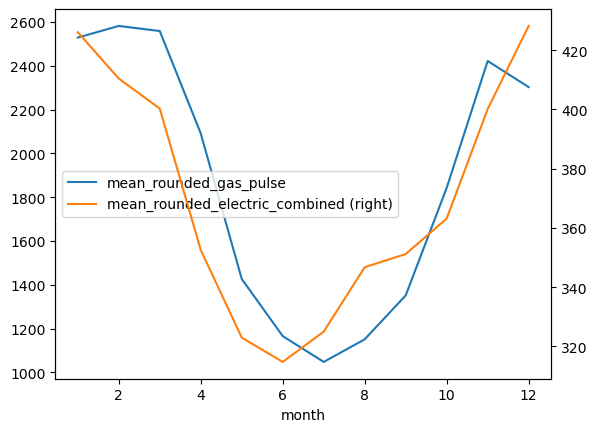

In [ ]:
# average value of each month
monthly_energy = original.copy().groupby(by=['month'])[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
monthly_energy.plot(secondary_y='mean_rounded_electric_combined')

In [ ]:
original.rename(columns={'household_id':'homeid'}, inplace=True)
original

,homeid,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0,2017,3
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,NaN,253.0,2017,3
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0,2017,3
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0,2017,3
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...
71601,99,2018-06-26,16.0,11.0,Partly Cloudy,1.0,False,False,941.0,331.0,2018,6
71602,99,2018-06-27,22.0,12.0,Partly Cloudy,2.0,False,False,907.0,391.0,2018,6
71603,99,2018-06-28,28.0,11.0,Clear,3.0,False,False,702.0,360.0,2018,6
71604,99,2018-06-29,16.0,9.0,Partly Cloudy,4.0,False,False,895.0,500.0,2018,6


the data pre processing of outliers is done.

# dealing with the missing value during the period of min max datetime

In [ ]:
# name the dataset as energy_use
energy_use = original.copy()

In [ ]:
# check how many data should be in period
print('start date:', energy_use['datetime'].min())
print('end date:', energy_use['datetime'].max())

days = energy_use['datetime'].unique()
print('total days:', len(days))

homes = energy_use['homeid'].unique()
print('total homes:', len(homes))

total_rows = len(days) * len(homes)

print('total rows shold be:', total_rows)
print('but actual total rows:', len(energy_use))

start date: 2016-08-10 00:00:00
end date: 2018-06-30 00:00:00
total days: 690
total homes: 255
total rows shold be: 175950
but actual total rows: 71606


# Generate dataset that have completed period of datetime


In [ ]:
# generate a new dataframe with all the days in the period and all the households
# this will allow us to fill in missing values

# get all the days in the period
all_days = pd.date_range(start=energy_use['datetime'].min(), end=energy_use['datetime'].max(), freq='D')
print('number of days:', all_days.shape)

# get all the households
all_houses = energy_use['homeid'].unique()
print('number of households:', all_houses.shape)

# create a new dataframe with all the days and all the households, set index to homeid
all_combinations = pd.MultiIndex.from_product([all_houses, all_days], names=['homeid','datetime'])
all_combinations = pd.DataFrame(index=all_combinations).reset_index()
all_combinations.shape

number of days: (690,)
number of households: (255,)


(175950, 2)

In [ ]:
# Now merge the all_combinations with the original energy use data
complete_data = pd.merge(all_combinations, energy_use, how='left', on=['homeid','datetime'])
complete_data.shape

(175950, 12)

In [ ]:
complete_data['year'] = complete_data['datetime'].dt.year
complete_data['month'] = complete_data['datetime'].dt.month
complete_data['day_of_week'] = complete_data['datetime'].dt.dayofweek

# check for missing values
complete_data.isnull().sum()

homeid                                 0
datetime                               0
maxtemp                           116511
mintemp                           116511
conditions                        116511
day_of_week                            0
is_weekend                        116511
is_bank_holiday                   116511
mean_rounded_gas_pulse            117059
mean_rounded_electric_combined    109289
year                                   0
month                                  0
dtype: int64

In [ ]:
# drop the columns that have missing value, and are not needed
complete_data.drop(columns=['maxtemp','mintemp','is_weekend','is_bank_holiday','conditions'], inplace=True)

In [ ]:
# check average of gas_pulse and electric_combined for each month in complete_data
monthly_energy = complete_data.groupby(by=['month'])[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
monthly_energy


,mean_rounded_gas_pulse,mean_rounded_electric_combined
month,,
1,2528.376063,426.068660
2,2581.707536,410.420634
3,2558.296915,400.290306
4,2091.035153,352.550013
5,1426.686009,322.973836
6,1165.795016,314.749609
7,1047.964090,324.970523
8,1151.216616,346.724219
9,1351.539251,351.165017


# divded data into 12 dataframes by their months
we need to filling the missing value of each months. so firstly we need to divided dataset by each month, then using KNN method to impute missing values

In [ ]:
# divided complete_data into 12 individual dataframes by each month
months = [complete_data[complete_data['month'] == i] for i in range(1, 13)]

# check data for month 1
months[0].head()


,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month
144,100,2017-01-01,6,NaN,NaN,2017,1
145,100,2017-01-02,0,NaN,NaN,2017,1
146,100,2017-01-03,1,NaN,NaN,2017,1
147,100,2017-01-04,2,NaN,NaN,2017,1
148,100,2017-01-05,3,NaN,NaN,2017,1


In [ ]:
# validation, check the length of each month, and the sum of length should be equal to the length of complete_data 175950

# check each month's length, and the sum of length should be equal to the length of complete_data
print('length of each month:')
for i, month in enumerate(months):
    print('month', i+1, ':', len(month))

print('total length of all months:', sum([len(month) for month in months]))

length of each month:
month 1 : 15810
month 2 : 14280
month 3 : 15810
month 4 : 15300
month 5 : 15810
month 6 : 15300
month 7 : 7905
month 8 : 13515
month 9 : 15300
month 10 : 15810
month 11 : 15300
month 12 : 15810
total length of all months: 175950


# Fill the missing data by each month's dataframe

intend to use Mutiple Imputation method (KNN imputation method have high calculation cost)

 filling missing value according to other columns such as conditions (weather), day of week, is weekend, is bank holiday, max and min temp, heating type...
 

Addtional data: 'hometype'


In [ ]:
# find home type data
home_type = pd.read_csv('../data/home.csv')
home_type = home_type[['homeid', 'hometype']]

In [ ]:
# merge home_type with each month data
for i, month in enumerate(months):
    months[i] = pd.merge(month, home_type, how='left', on='homeid')

# check data for month 1
months[0].head()

,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month,hometype
0,100,2017-01-01,6,NaN,NaN,2017,1,flat
1,100,2017-01-02,0,NaN,NaN,2017,1,flat
2,100,2017-01-03,1,NaN,NaN,2017,1,flat
3,100,2017-01-04,2,NaN,NaN,2017,1,flat
4,100,2017-01-05,3,NaN,NaN,2017,1,flat


# Multiple Imputation for daily gas and electricity  missing data of each "month" dataframe

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

In [ ]:
# define a function for encoding categorical features

def encode_categorical_features(df, column_names):
    label_encoder = LabelEncoder()
    for column in column_names:
        # Check if the column is in the DataFrame and is categorical
        if column in df.columns and df[column].dtype == 'object':
            # Convert to string type in case of mixed types
            df[column] = label_encoder.fit_transform(df[column].astype(str))
        else:
            # no need to encode
            pass
    return df

In [ ]:
# apply the function to each month's dataframe
for i in range(12):  # assming dataframes indexed from 0 to 11
    column_names = list(months[i].columns)
    months[i] = encode_categorical_features(months[i], column_names) 

In [ ]:
# check the dataframes of month 1
months[0].head()

,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month,hometype
0,100,2017-01-01,6,NaN,NaN,2017,1,0
1,100,2017-01-02,0,NaN,NaN,2017,1,0
2,100,2017-01-03,1,NaN,NaN,2017,1,0
3,100,2017-01-04,2,NaN,NaN,2017,1,0
4,100,2017-01-05,3,NaN,NaN,2017,1,0


In [ ]:
months[0].isnull().sum()

homeid                                0
datetime                              0
day_of_week                           0
mean_rounded_gas_pulse            11106
mean_rounded_electric_combined     9489
year                                  0
month                                 0
hometype                              0
dtype: int64

# Imputation

- KNN method

KNN Imputation uses the k-nearest neighbors to impute missing values. The imputation is done based on the mean or median (or any other aggregate) of the k-nearest neighbors found in the training set. Each feature's missing value is imputed using the non-missing values that are closest to that record in Euclidean space.

In [ ]:
from sklearn.impute import KNNImputer

#  'months' is a list containing each month's DataFrame
# [month_1, month_2, ..., month_12]

# Define the columns to impute
columns_to_impute = ['mean_rounded_gas_pulse', 'mean_rounded_electric_combined']

# Create an imputer object with a specific number of neighbors
imputer = KNNImputer(n_neighbors=10, weights="distance")

# Loop through each DataFrame in the list
for i in range(len(months)):
    # Select only the columns that need imputation to avoid fitting the imputer to unnecessary data
    df_subset = months[i][columns_to_impute]
    
    # Apply fit_transform to the subset and then assign the imputed data back to the original DataFrame
    months[i][columns_to_impute] = imputer.fit_transform(df_subset)
    
    # Optional: Output to check progress
    print(f"Imputation completed for Month {i+1}")


Imputation completed for Month 1
Imputation completed for Month 2
Imputation completed for Month 3
Imputation completed for Month 4
Imputation completed for Month 5
Imputation completed for Month 6
Imputation completed for Month 7
Imputation completed for Month 8
Imputation completed for Month 9
Imputation completed for Month 10
Imputation completed for Month 11
Imputation completed for Month 12


In [ ]:
# check average of gas_pulse and electric_combined for each month
average_monthly_energy = [month[['mean_rounded_gas_pulse', 'mean_rounded_electric_combined']].mean() for month in months]
average_monthly_energy = pd.DataFrame(average_monthly_energy, index=range(1,13))
average_monthly_energy


,mean_rounded_gas_pulse,mean_rounded_electric_combined
1,2586.759327,422.116535
2,2615.200340,416.742906
3,2604.266548,399.031551
4,2118.828973,348.847937
5,1433.623310,322.427827
6,1167.471543,322.825262
7,1049.054115,325.186205
8,1152.380097,346.717329
9,1356.361188,349.738826
10,1852.353849,360.489092


In [ ]:
# check the imputation result of dataframes of month 1
months[0].isnull().sum()

homeid                            0
datetime                          0
day_of_week                       0
mean_rounded_gas_pulse            0
mean_rounded_electric_combined    0
year                              0
month                             0
hometype                          0
dtype: int64

now the imputation work is finished for each of "months" data

In [ ]:
# combine all the 12 dataframes into one
complete_data_imputed = pd.concat(months, ignore_index=True)
complete_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175950 entries, 0 to 175949
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   homeid                          175950 non-null  int64         
 1   datetime                        175950 non-null  datetime64[ns]
 2   day_of_week                     175950 non-null  int32         
 3   mean_rounded_gas_pulse          175950 non-null  float64       
 4   mean_rounded_electric_combined  175950 non-null  float64       
 5   year                            175950 non-null  int32         
 6   month                           175950 non-null  int32         
 7   hometype                        175950 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(1)
memory usage: 8.1 MB


we have finished imputation work for each months, and get a completed dataframe

In [ ]:
# check the date range of the complete_data_imputed
# check time period
print('start date:', complete_data_imputed['datetime'].min())
print('end date:', complete_data_imputed['datetime'].max())

days = complete_data_imputed['datetime'].unique()
print('total days:', len(days))

homes = complete_data_imputed['homeid'].unique()
print('total homes:', len(homes))

total_rows = len(days) * len(homes)

print('total rows shold be:', total_rows)
print('actual total rows:', len(complete_data_imputed))

start date: 2016-08-10 00:00:00
end date: 2018-06-30 00:00:00
total days: 690
total homes: 255
total rows shold be: 175950
actual total rows: 175950


# select a full year data

we need select a whole year 365 data points, because we calculate energy poverty by annual income.

In [ ]:
# check which period of a whole year 365 days, that most of homes have most of gas_pulse and electric_combined , have most no nan values

original_data = complete_data.copy()

# Group by year and month, and then apply a custom aggregation to count non-NaN entries
monthly_data_availability = original_data.groupby(['year', 'month']).apply(lambda df: df[['mean_rounded_gas_pulse', 'mean_rounded_electric_combined']].notna().sum()).reset_index()

# Rename columns for clarity
monthly_data_availability.columns = ['year', 'month', 'non_nan_gas', 'non_nan_electric']
monthly_data_availability

,year,month,non_nan_gas,non_nan_electric
0,2016,8,36,36
1,2016,9,90,90
2,2016,10,163,162
3,2016,11,293,249
4,2016,12,384,379
5,2017,1,522,572
6,2017,2,772,913
7,2017,3,1058,1268
8,2017,4,1189,1289
9,2017,5,1328,1328


we can see the period from 2017-6 to 2018-6 have most non nan values, which means they have most of non imputed data, so this period is ideal to use.

then we will select the data in comleted imputed dataset from period from 2017-7 to 2018-6, total 12 months

In [ ]:
# we need to select a whole year of data, because when calculate energy poverty, the income is annual one.

data_select = complete_data_imputed[(complete_data_imputed['datetime'] >= '2017-07-01') & (complete_data_imputed['datetime'] < '2018-07-1')]

In [ ]:
# check the date range of data_select
print('start date:', data_select['datetime'].min())
print('end date:', data_select['datetime'].max())

days = data_select['datetime'].unique()
print('total days:', len(days))

homes = data_select['homeid'].unique()
print('total homes:', len(homes))

total_rows = len(days) * len(homes)

print('total rows shold be:', total_rows)
print('actual total rows:', len(data_select))

start date: 2017-07-01 00:00:00
end date: 2018-06-30 00:00:00
total days: 365
total homes: 255
total rows shold be: 93075
actual total rows: 93075


In [ ]:
data_select.to_csv('../Lin_EP_test/daily_energy_demand_imputation.csv', index=False)

<Axes: title={'center': 'Average hourly gas and electric each month'}, xlabel='month'>

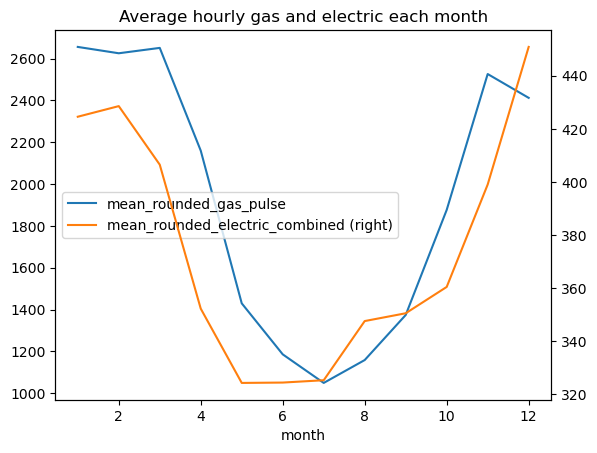

In [ ]:
# now plot average montly gas_pulse and electric_combined for all households
# put the gas_pulse on the left y-axis and the electric_combined on the right y-axis
month = data_select.copy()
month['month'] = month['datetime'].dt.month
grouped = month.groupby(by='month')[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
grouped.plot(secondary_y='mean_rounded_electric_combined', title='Average hourly gas and electric each month')

<Axes: title={'center': 'Average hourly gas and electric for datetime_range'}, xlabel='date'>

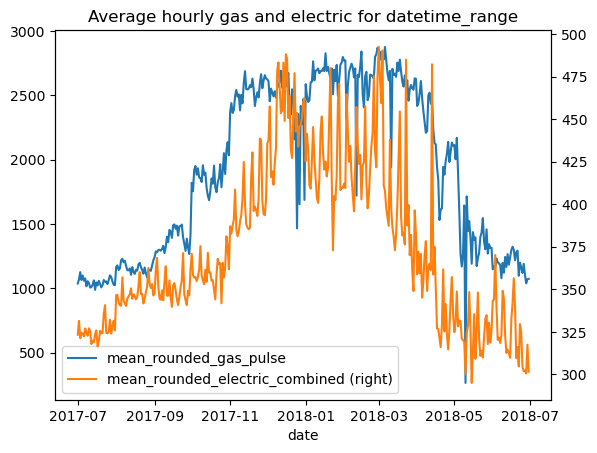

In [ ]:
# now plot average daily gas_pulse and electric_combined for all households, put the gas_pulse on the left y-axis and the electric_combined on the right y-axis
datetime_range = data_select.copy()
datetime_range['date'] = datetime_range['datetime'].dt.date
grouped = datetime_range.groupby(by='date')[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
grouped.plot(secondary_y='mean_rounded_electric_combined', title='Average hourly gas and electric for datetime_range')

<Axes: title={'center': 'Average hourly total energy for each season'}, xlabel='season'>

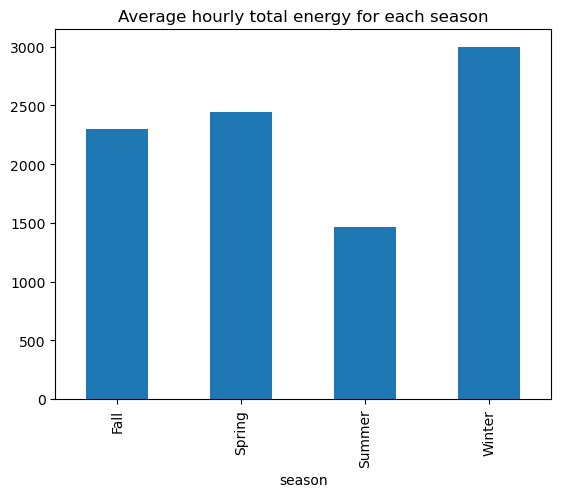

In [ ]:
# now plot average daily gas_pulse and electric_combined for each season for all households
season = data_select.copy()
season['energy'] = season['mean_rounded_electric_combined'] + season['mean_rounded_gas_pulse']
season['season'] = season['datetime'].dt.month % 12 // 3
season['season'] = season['season'].map({0:'Winter', 1:'Spring', 2:'Summer', 3:'Fall'})
grouped = season.groupby(by='season')['energy'].mean()
grouped.plot( title='Average hourly total energy for each season', kind='bar')



In [ ]:
data_select

,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month,hometype
31,100,2018-01-01,0,2098.166667,456.0,2018,1,0
32,100,2018-01-02,1,3249.200000,239.0,2018,1,0
33,100,2018-01-03,2,2925.285714,324.0,2018,1,0
34,100,2018-01-04,3,3133.000000,201.0,2018,1,0
35,100,2018-01-05,4,2900.200000,225.0,2018,1,0
...,...,...,...,...,...,...,...,...
175945,99,2017-12-27,2,1758.000000,1316.0,2017,12,1
175946,99,2017-12-28,3,3188.285714,494.0,2017,12,1
175947,99,2017-12-29,4,5374.000000,855.0,2017,12,1
175948,99,2017-12-30,5,2125.000000,614.0,2017,12,1


In [ ]:
# average of gas_pulse and electric_combined for all selected dataset
data_select[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()

mean_rounded_gas_pulse            1920.779922
mean_rounded_electric_combined     374.216920
dtype: float64

In [ ]:
original_data[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()

mean_rounded_gas_pulse            1900.806082
mean_rounded_electric_combined     372.756754
dtype: float64

# Conclusion

- seleted dataset (with imputed missing data)


Gas: 1920 watt hour

Electricity: 374.2 watt hour



- original: 

Gas: 1900 watt hour

Electricity: 372.75 watt hour


- benchmark: 

Gas: 1626 watt hour

Electricity: 375 watt hour

- conclusion

that seleted dataset (with imputed data), which contain average gas use and electricity use of 255 homes from 2017-07-01 to 2018-06-30 (total 12 months) were close to both original dataset and benchmark. so we can use this full one year full dataset to do furthur analysis.


